# Messages throughput

In this notebook, we do an analysis of the average amount of messages we get to send compressed per second for a worst case scenario of a payload with a high entropy composed of random numbers.

For this we ran as a publisher:
```
 ./target/release/examples/z_pub_thr 8 -m peer --no-multicast-scouting -e tcp/127.0.0.1:7447
```
and as a receiver
```
./target/release/examples/z_sub_thr -m peer --no-multicast-scouting -l tcp/127.0.0.1:7447 -n 10000 -s 1000
```

varying the size of the messages size from 8 bytes to 56KB. For 64KB message size an error occurs that is yet to be determined what happened (something related to the orchestrator).

A python script was used to generate all the output results, which can be found on this repo under script.py:

In [63]:
cat ../script.py

import subprocess

KB = 1024

SIZES = [8, 16, 32, 64, 128, 256, 512, KB, 2*KB, 4*KB, 8*KB, 16*KB, 24*KB, 32*KB, 40*KB, 48*KB, 56*KB, 64*KB]

def run_compression():
    rcv_cmds = ["./target/release/examples/z_sub_thr", "-m", "peer", "--no-multicast-scouting", "-l", "tcp/127.0.0.1:7447", "-n", "10000", "-s", "1000"]
    for size in SIZES:
        send_cmds = ["./target/release/examples/z_pub_thr", str(size), "-m", "peer", "--no-multicast-scouting", "-e", "tcp/127.0.0.1:7447"]
        log_file = "compression_logs/compression_" + str(size) + ".txt"
        f = open(log_file, "w")
        sender = subprocess.Popen(send_cmds)
        receiver = subprocess.Popen(rcv_cmds, stdout=f)
        receiver.wait()
        sender.terminate()

run_compression()


In [64]:
import pandas as pd
import matplotlib.pyplot as plt


In [65]:
KB = 1024
SIZES = [8, 16, 32, 64, 128, 256, 512, KB, 2*KB, 4*KB, 8*KB, 16*KB, 24*KB, 32*KB, 40*KB, 48*KB, 56*KB]

In [66]:
def parse_file(filename):
    file = open(filename, 'r')
    lines = file.readlines()
    measurements = []
    for line in lines:
        measurement = line.strip(' msg/s\n')
        measurements = measurements + [float(measurement)]
    return measurements
        

In [67]:
a = [1,2,3]
a = a + [4]
a

[1, 2, 3, 4]

In [68]:
import numpy as np

def calculate_avg_msgs(measurements):
    return np.average(measurements)

In [69]:
averages = {}
for size in SIZES:
    averages[size] = calculate_avg_msgs(parse_file('../compression_logs/compression_' + str(size) + '.txt'))

print(averages)

{8: 5378645.953882225, 16: 5783656.311262258, 32: 5552940.087370603, 64: 5417696.827440016, 128: 5151715.08816932, 256: 4746169.02903994, 512: 4066103.221182908, 1024: 3522292.0222718734, 2048: 2713795.6353271957, 4096: 1803642.017406879, 8192: 962495.5768201667, 16384: 449419.70148930146, 24576: 296131.095837066, 32768: 181446.95648821606, 40960: 169775.48061210132, 49152: 151003.83455338067, 57344: 143599.89304593712}


In [70]:
df = pd.DataFrame(averages.items())

In [71]:
df

,0,1
0,8,5.378646e+06
1,16,5.783656e+06
2,32,5.552940e+06
3,64,5.417697e+06
4,128,5.151715e+06
5,256,4.746169e+06
6,512,4.066103e+06
7,1024,3.522292e+06
8,2048,2.713796e+06
9,4096,1.803642e+06


In [72]:
def plot_messages_per_second():
    fig, ax = plt.subplots()

    ax.plot(df[0], df[1], label="msgs/s", marker='o')

    ax.set_xticks(df[0])
    ax.set_ylabel('Msgs/s')
    ax.set_xlabel('Message size')
    ax.set_xscale('log')
    ax.set_title('Average messages per second depending on the size of the message with compression with a high entropy payload')
    ax.grid(True)
    ax.legend(loc='center right', ncols=1)
    fig.set_figwidth(15)
    # ax.tick_params(labelcolor='r', labelsize='medium', width=3)
    plt.show()


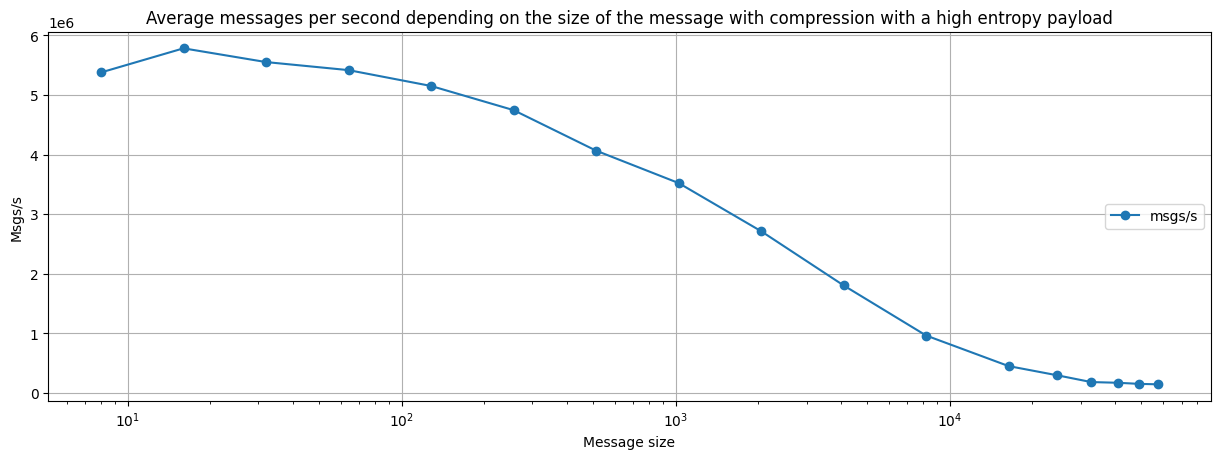

In [73]:
plot_messages_per_second()